In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# Imported Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches
import time
import statistics as st
from sklearn.metrics import log_loss
# Classifier Libraries
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import collections
from xgboost import XGBClassifier
# Sampling Data
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report,confusion_matrix
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
from yellowbrick.classifier import roc_auc
warnings.filterwarnings("ignore")
sns.set_style('dark')

In [2]:
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [27]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [28]:
(len(data['Time'].value_counts())/data.shape[0])*100

43.746115790693345

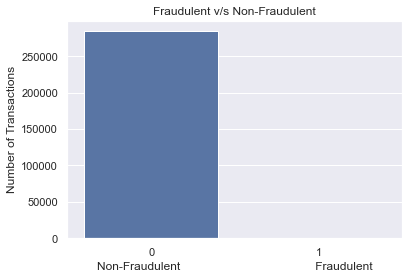

Total number of Non-Fraudulent Transaction:  284315
Total number of Fraudulent Transaction:  492
Percentage of data in Fraudulent Class = 0.1727485630620034 %
Percentage of data in Non-Fraudulent Class = 99.82725143693798 %


In [6]:
sns.set_theme(style="darkgrid")
sns.countplot(data['Class'])
plt.title("Fraudulent v/s Non-Fraudulent")
plt.xlabel("Non-Fraudulent                                        Fraudulent")
plt.ylabel("Number of Transactions")
plt.show()
print("Total number of Non-Fraudulent Transaction: ",data[data.Class==0].shape[0])
print("Total number of Fraudulent Transaction: ",data[data.Class==1].shape[0])
print(f"Percentage of data in Fraudulent Class = {((data[data.Class==1].shape[0])/(data.shape[0])*100)} %")
print(f"Percentage of data in Non-Fraudulent Class = {((data[data.Class==0].shape[0])/(data.shape[0])*100)} %")

The data is highly imbalanced. <br>
By this we can see that if we mark all the transaction as Non-Fraudulent, we would get a accurac level above 99.80%. <br>
Hence we would need a better metric to measure our model. We would use Confusion Matrix, Precisio and Recall for this. <br>

The first task is to prepair our data in a way that these fradaulant transactions are being noticed by our model
and identified.

In [13]:
# Seperating the dependent and independent variables
data.dropna(inplace=True)
y = data['Class']
X = data.loc[:, data.columns != 'Class']

In [20]:
# This function would return samples variables, i have used 4 different options of sampling in this case.
# Would try modelling on all the 4 sampled data and check which one performs better.
def sampling_data(X,y,option="SMOTE",strategy = "auto"):
    if option.lower()=="smote":
        smo = SMOTE(random_state=52,sampling_strategy = strategy)
        smo.fit(X, y)
        X_resampled, y_resampled = smo.fit_sample(X, y)
        return X_resampled, y_resampled
    elif option.lower()=="undersample":
        rus = RandomUnderSampler(random_state=42,sampling_strategy = strategy)
        rus.fit(X, y)
        X_resampled, y_resampled = rus.fit_sample(X, y)
        return X_resampled, y_resampled
    elif option.lower()=="oversample":
        ros = RandomOverSampler(random_state=42,sampling_strategy = strategy)
        ros.fit(X, y)
        X_resampled, y_resampled = ros.fit_sample(X, y)
        return X_resampled, y_resampled
    elif option.lower()=="nearmiss":
        near = NearMiss(sampling_strategy = strategy)
        near.fit(X, y)
        X_resampled, y_resampled = near.fit_sample(X, y)
        return X_resampled, y_resampled
    else:
        print("Please select from the below options: ")
        print("1: Undersample || 2: Oversample || 3: Nearmiss || 4. SMOTE")

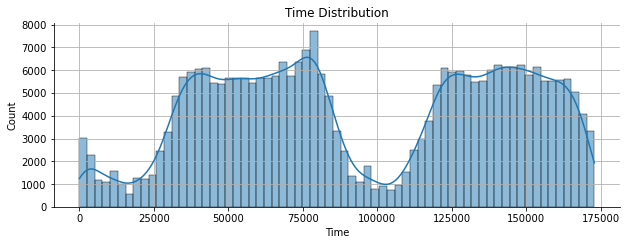

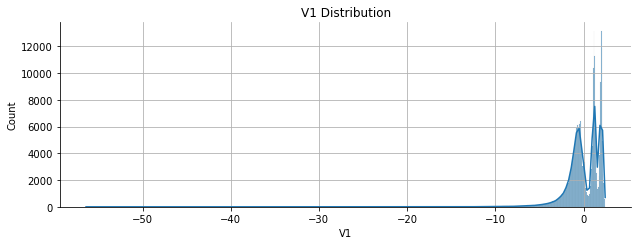

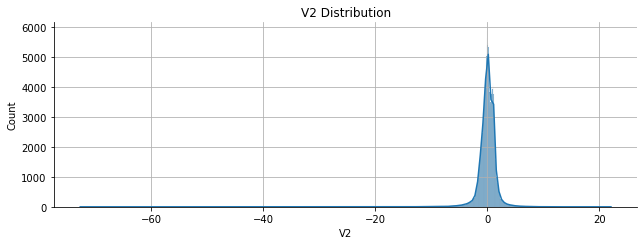

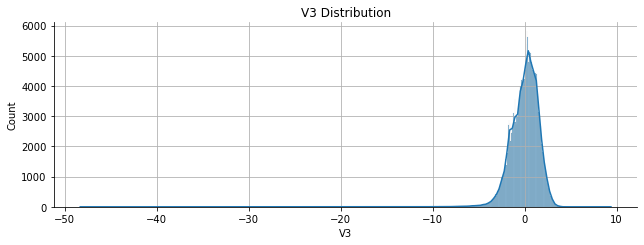

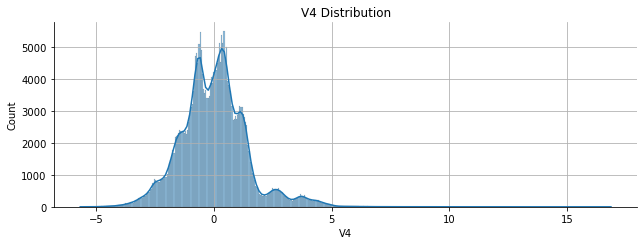

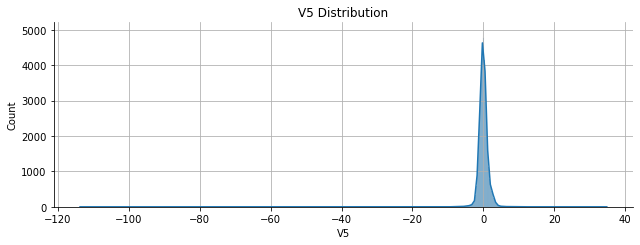

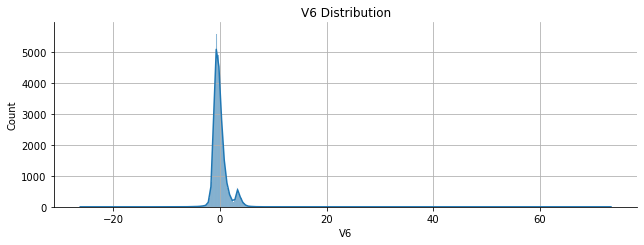

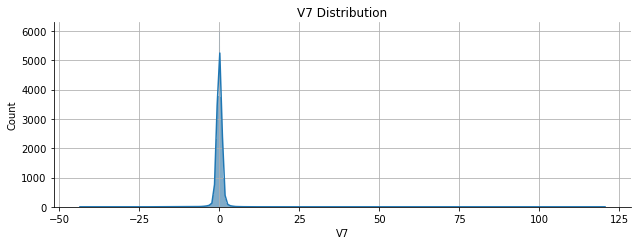

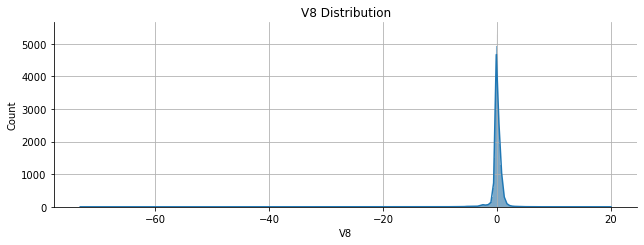

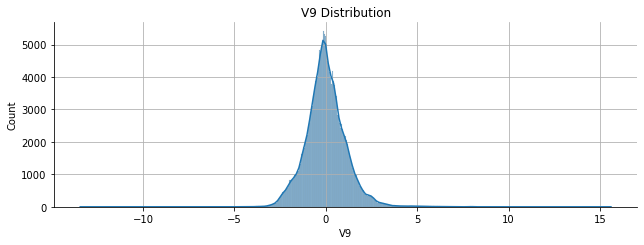

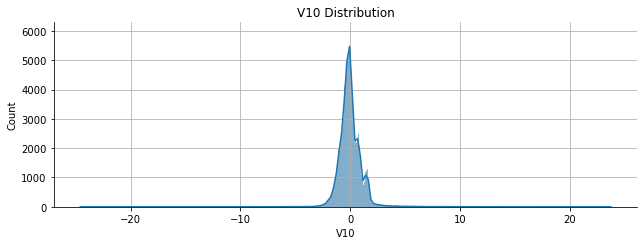

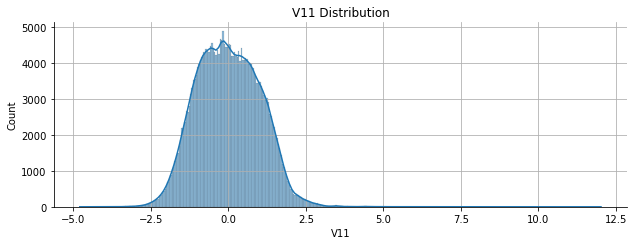

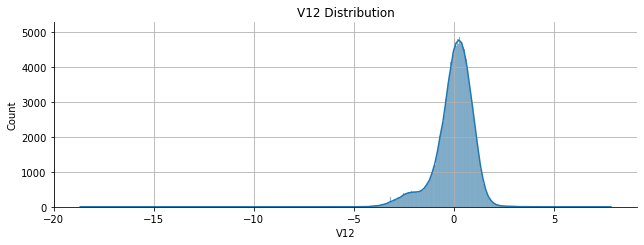

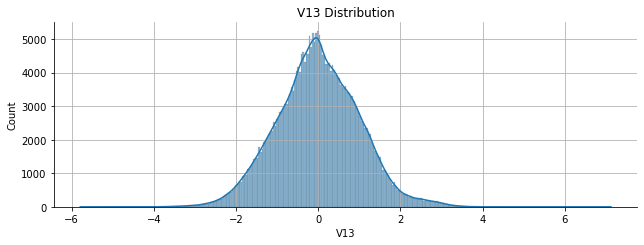

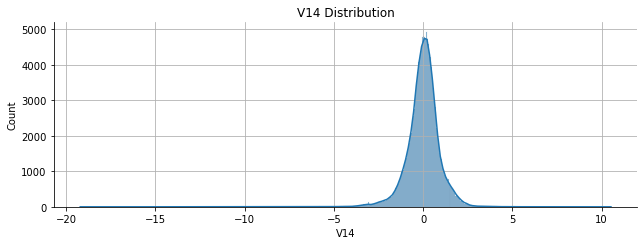

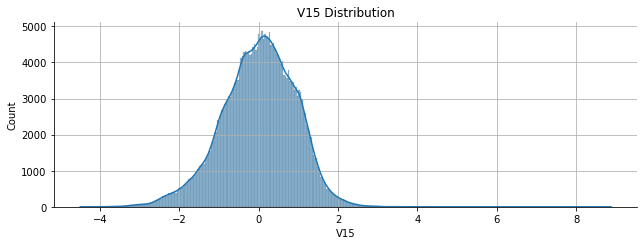

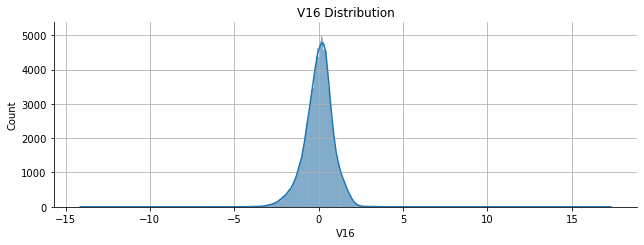

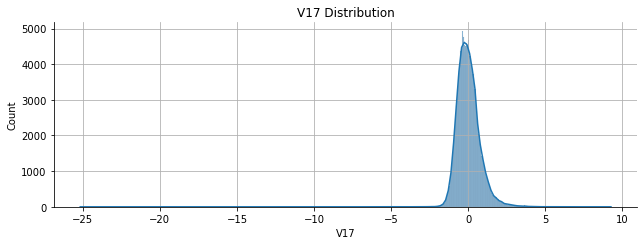

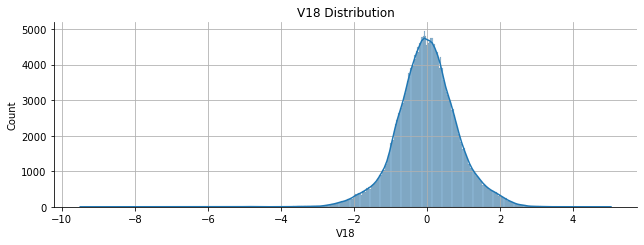

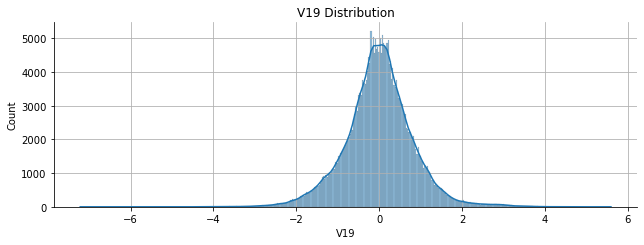

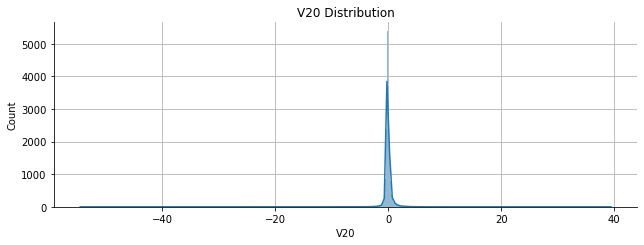

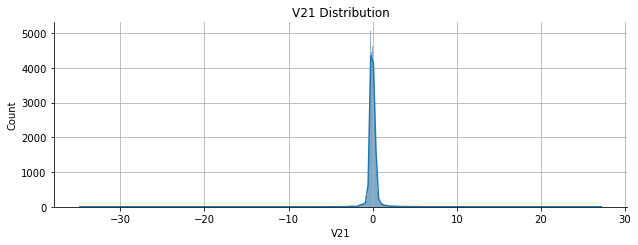

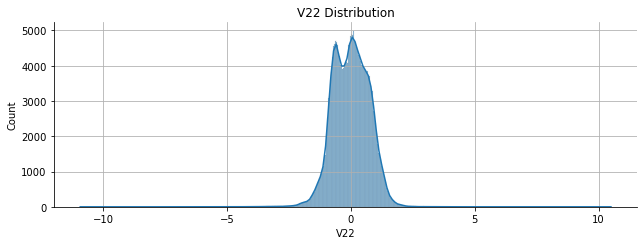

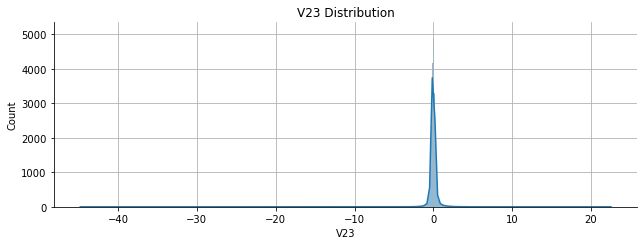

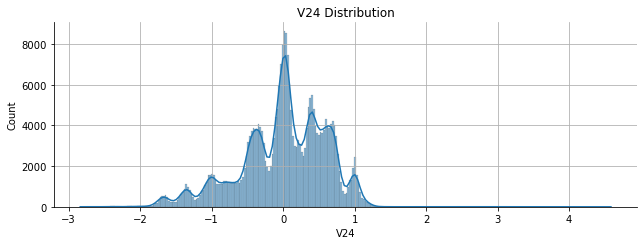

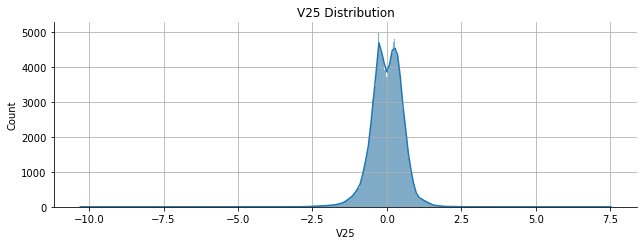

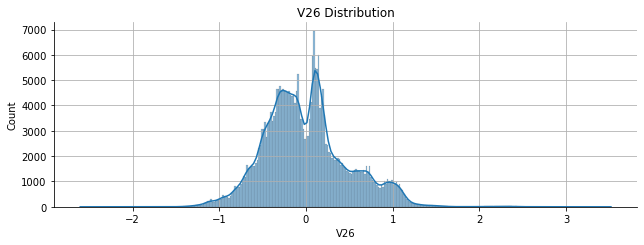

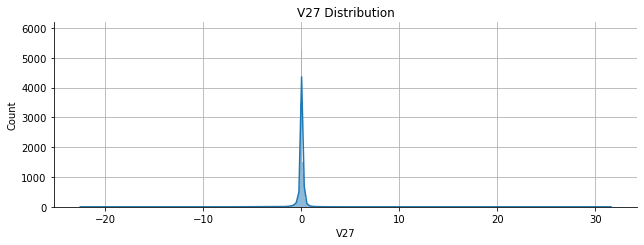

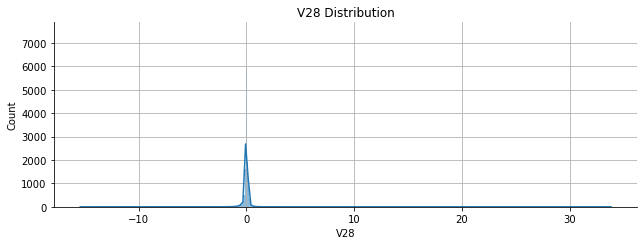

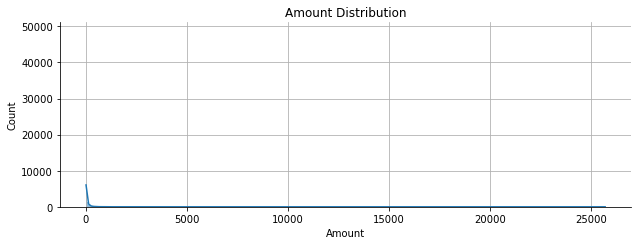

As we can see from here, all the distribution of our data are skewed
We would implement algorithms to make the data more Normal


In [130]:
col = data.loc[:, data.columns != 'Class'].columns
for i in col:
    g = sns.displot(data[i],kde= True)
    g.fig.set_figwidth(10)
    g.fig.set_figheight(3)
    plt.title(f"{i} Distribution")
    plt.grid()
    plt.show()
print("As we can see from here, all the distribution of our data are skewed")
print("We would implement algorithms to make the data more Normal")

In [8]:
# Scaling Time and Amount
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [4]:
# We check for correlation among the freatures
def corr_mat(data,x_size=24,y_size=25):
    corr = pd.DataFrame(data).corr()
    plt.figure(figsize = (x_size,y_size))
    g = sns.heatmap(round(corr,4),cmap="PiYG",annot=True,linewidths=0.5);
    plt.show()

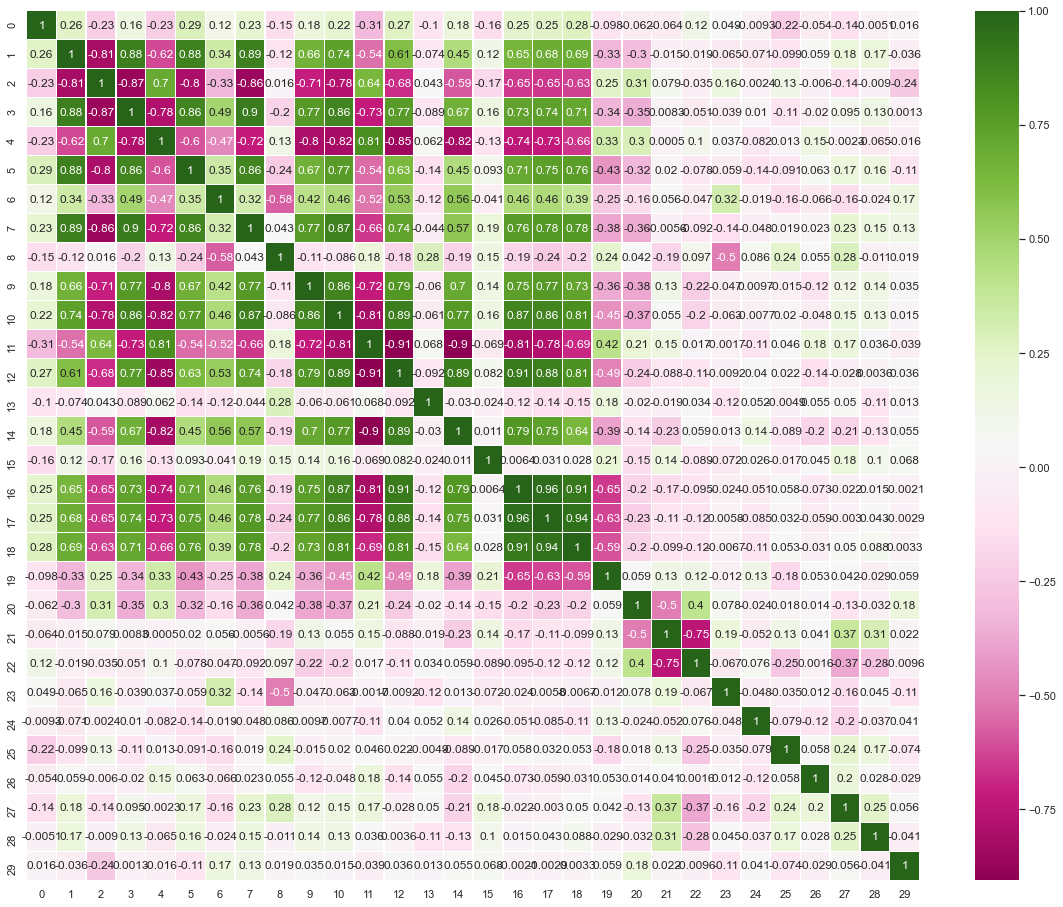

In [15]:
# We check for correlation among the freatures
X_1,y_1 = sampling_data(X,y,"smote")
corr_mat(X_1,20,16)

We can conclude that Sampling Creates, correlation among our features, which were previously not present.<br>
There is also negative correlation among or data, which is good for us. <br>
We would explore more on our correlated data.<br>

In [7]:
# Removing the column names that we do not need for the BoxPlot, to check its significance in predicting the lables
corr_col = list(data.iloc[:,:23].columns)
not_corr =['V8','V13','V15','V19','V20',"Time"]
output = [x for x in corr_col if not x in not_corr or not_corr.remove(x)]

In [6]:
def box_plot(y,data):    
    plt.figure(figsize = (10,8))
    sns.boxplot(x="Class", y=y, data=data, palette='twilight')
    plt.grid()
    plt.title(f'{i} vs Class Negative Correlation')
    plt.show()

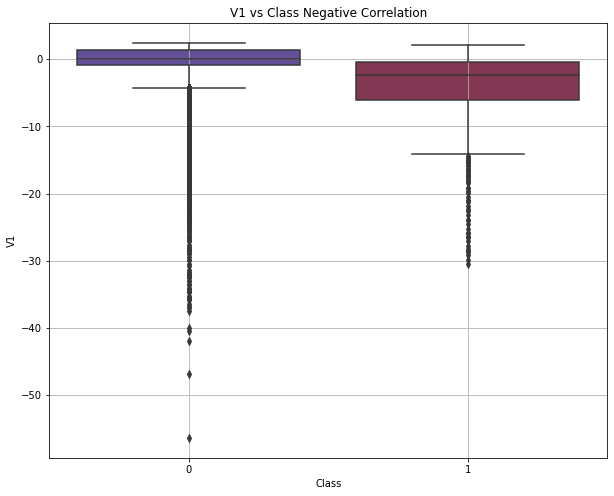

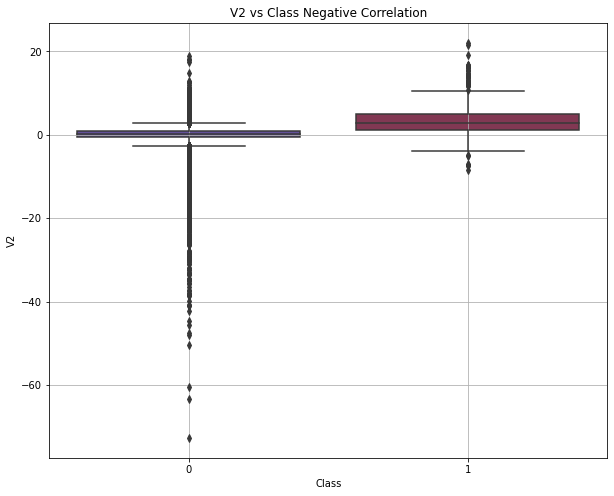

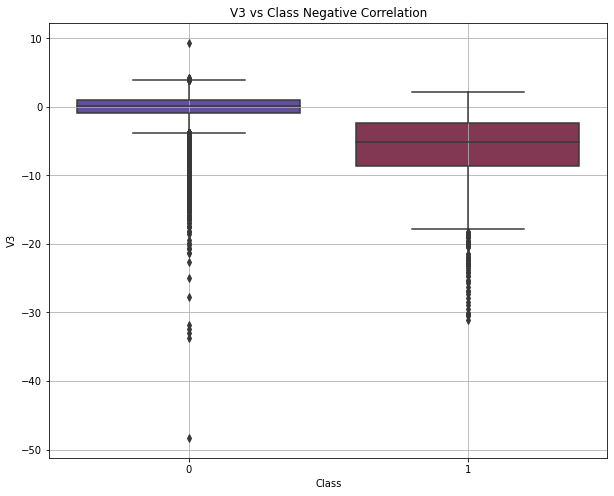

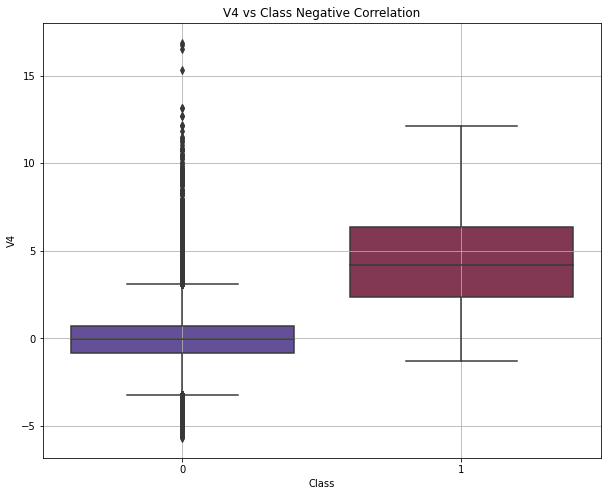

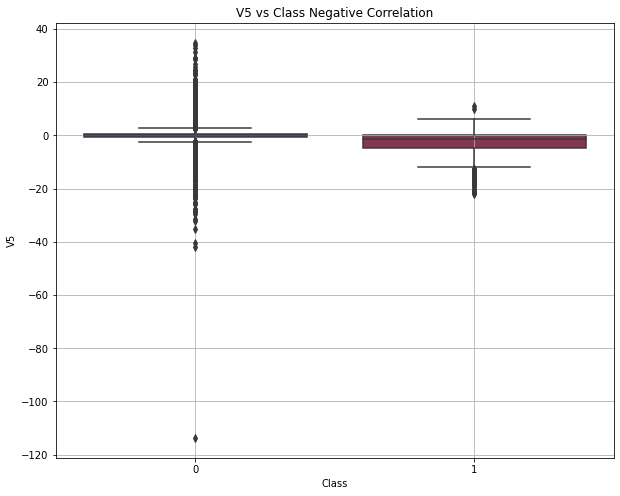

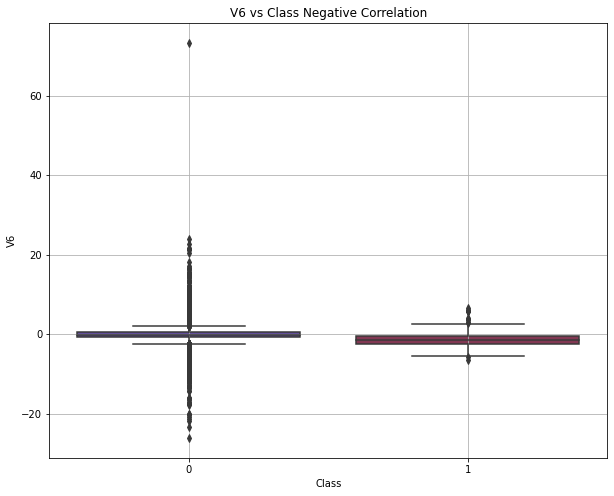

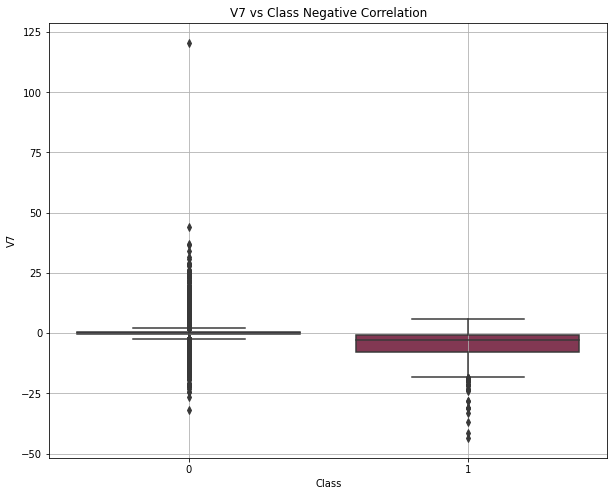

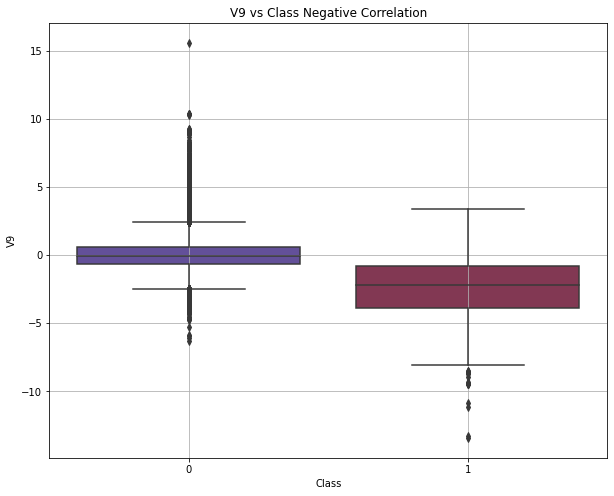

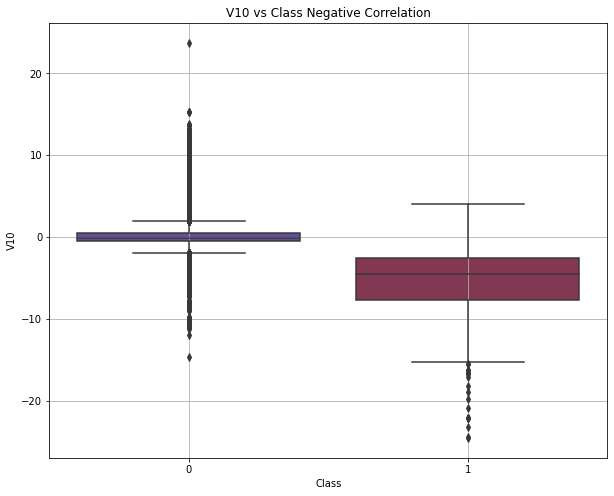

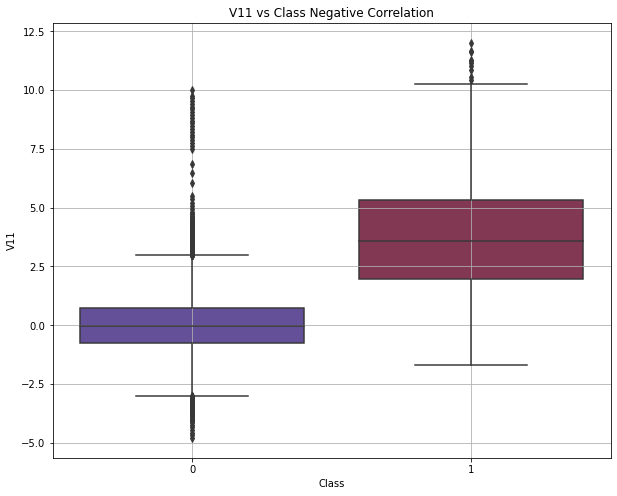

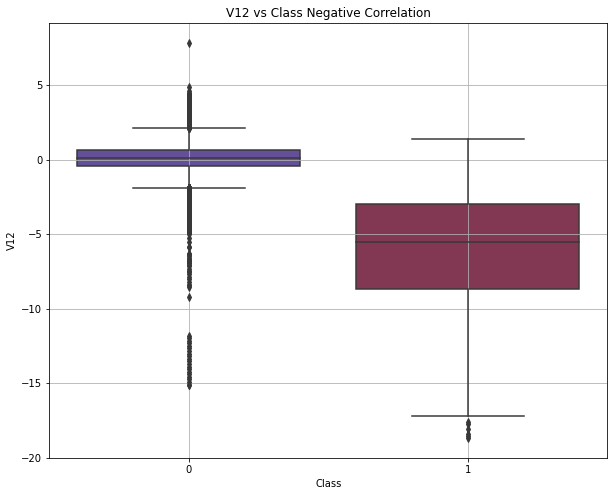

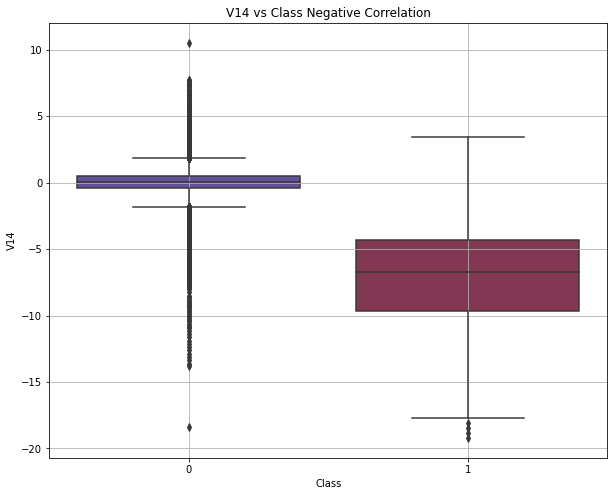

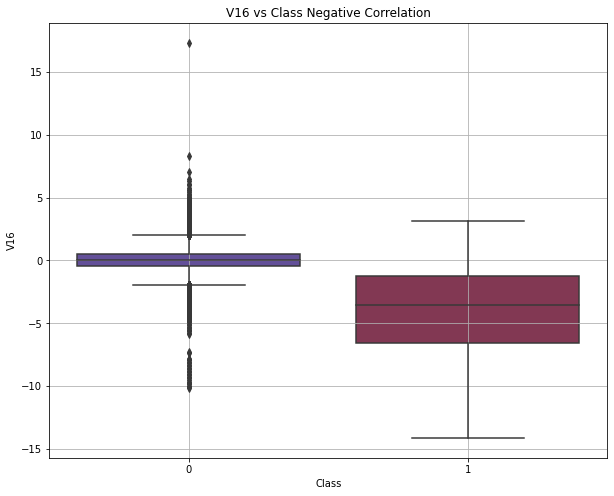

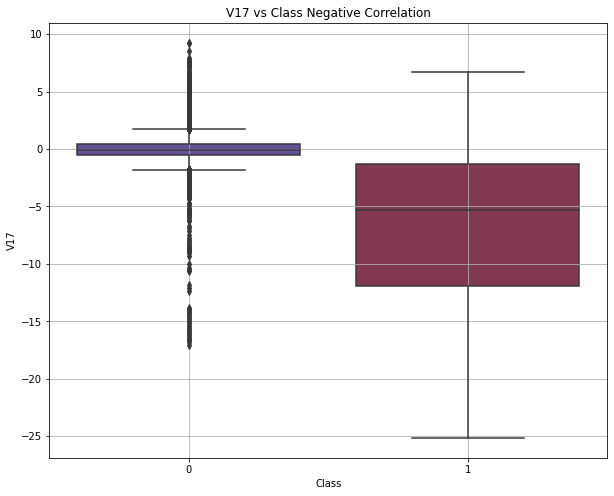

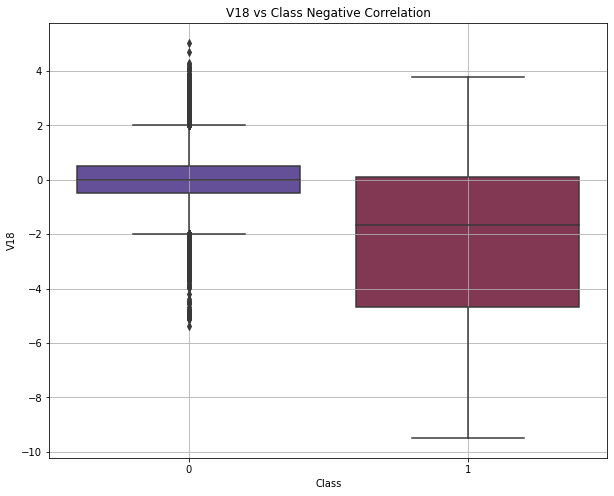

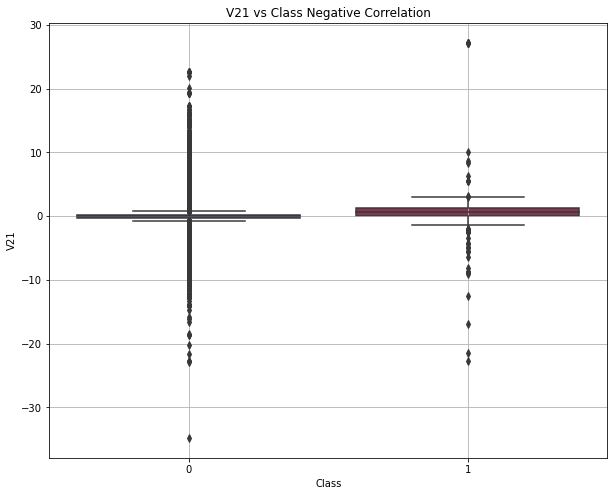

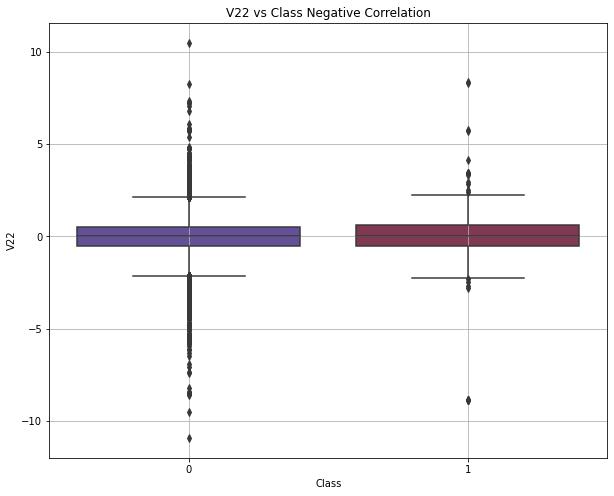

In [204]:
for i in output:
    box_plot(i,data)

We could find that the boxplot for "V22" feature mostly overlaps with our class lables. <br>Hence it would be difficult to seperate over this feature.

From this BoxPlot we could also see that there are some Outliers in our dataset. <br>We would be working to get rid of the Outliers.

In [7]:
# Removing data by percentile
# Removing Outliers
cols = data.loc[:, data.columns != 'Class'].columns
Q1 = data[data.Class==0][cols].quantile(0.20)
Q3 = data[data.Class==0][cols].quantile(0.80)
IQR = Q3 - Q1
data[data.Class==0] = data[data.Class==0][~((data[data.Class==0][cols] < (Q1 - 1.5 * IQR)) |(data[data.Class==0][cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [8]:
# Removing data by percentile
# Removing Outliers
cols = data.loc[:, data.columns != 'Class'].columns
Q1 = data[data.Class==1][cols].quantile(0.10)
Q3 = data[data.Class==1][cols].quantile(0.90)
IQR = Q3 - Q1
data[data.Class==1] = data[data.Class==1][~((data[data.Class==1][cols] < (Q1 - 1.5 * IQR)) |(data[data.Class==1][cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

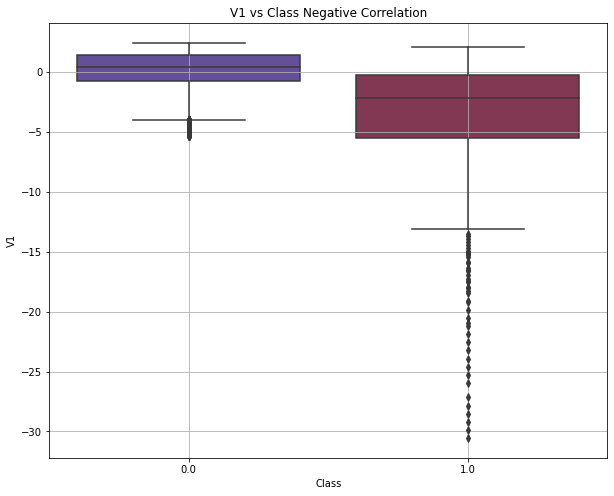

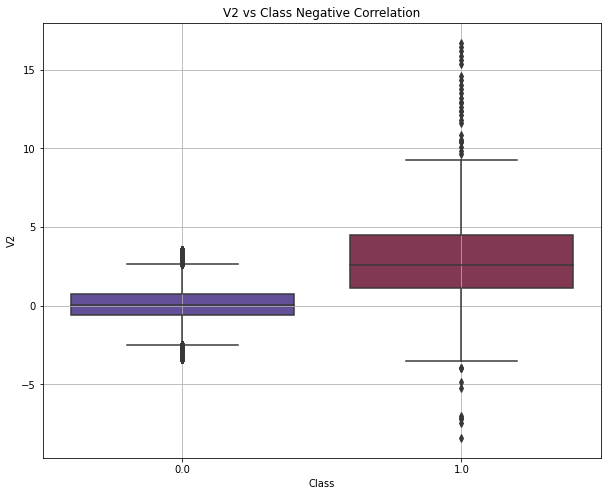

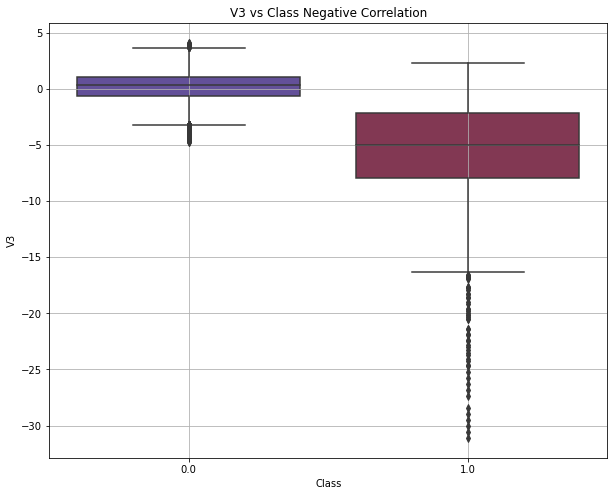

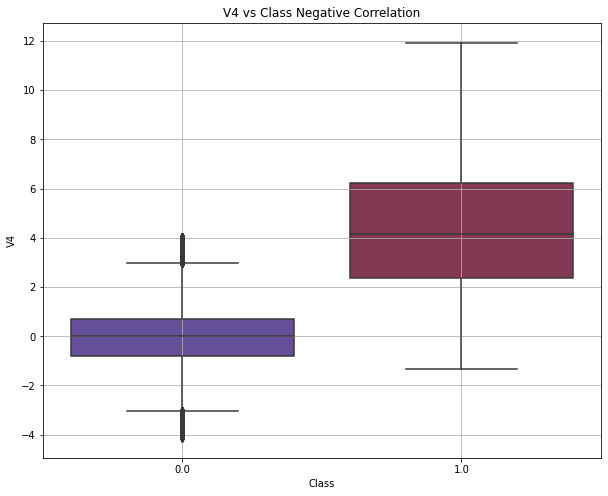

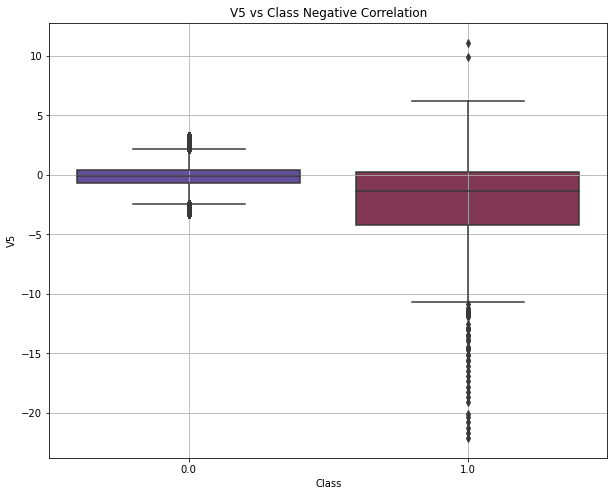

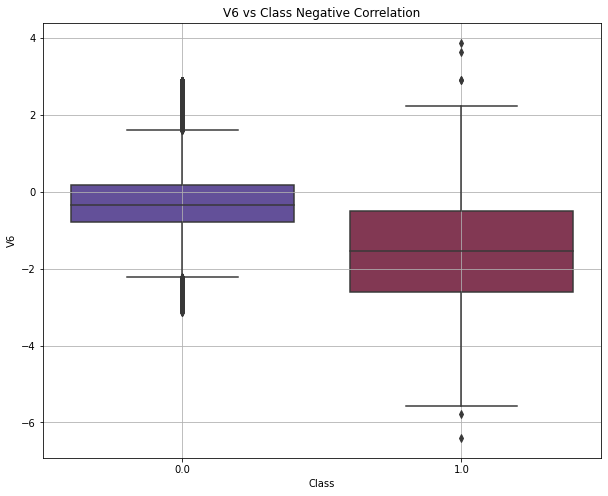

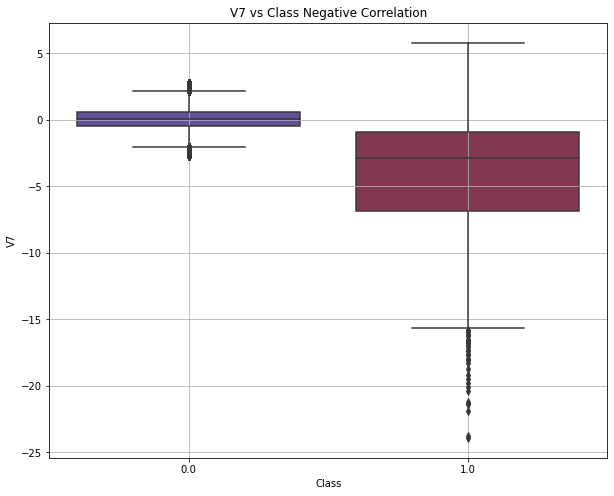

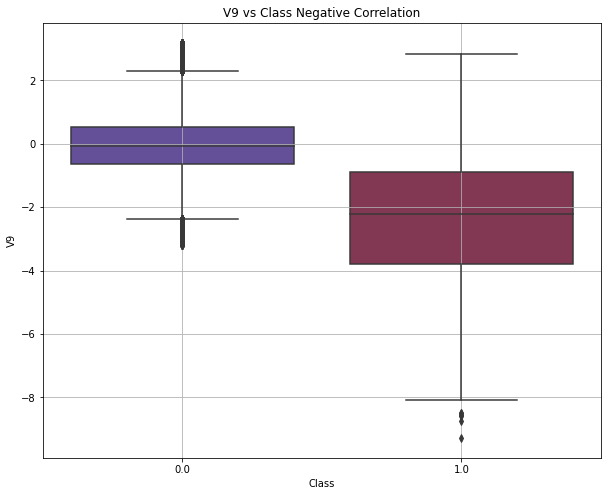

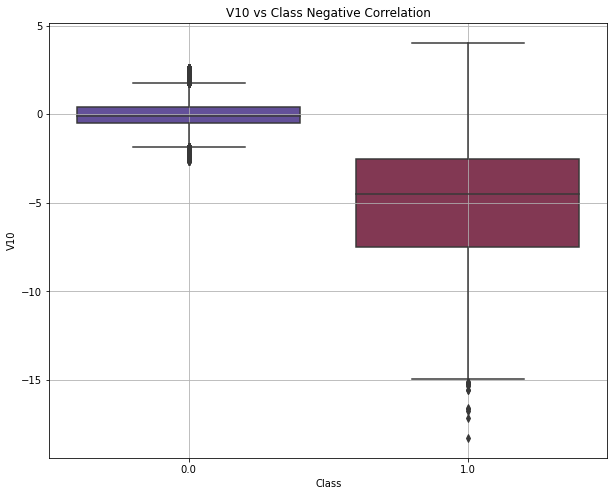

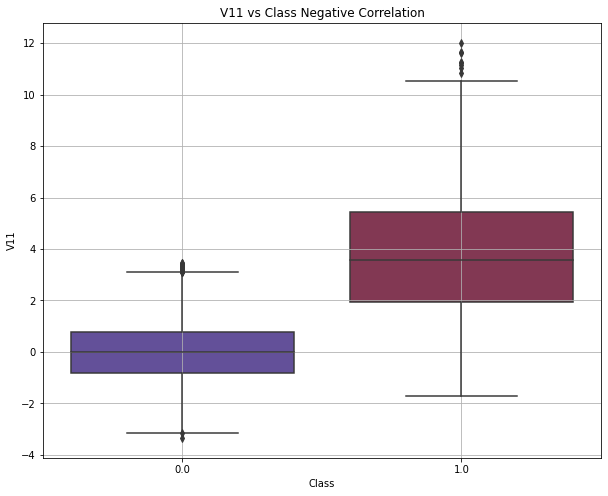

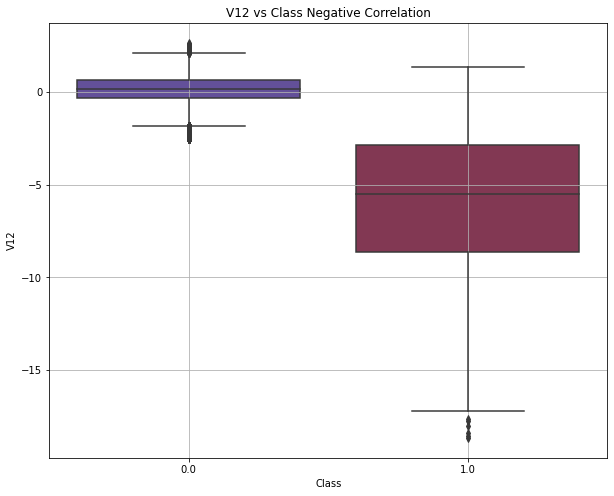

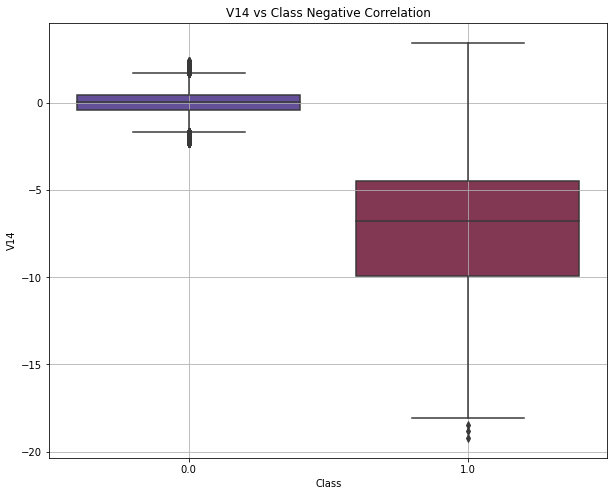

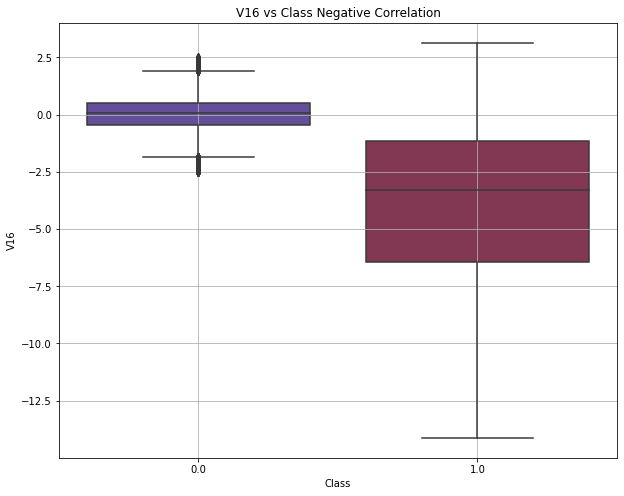

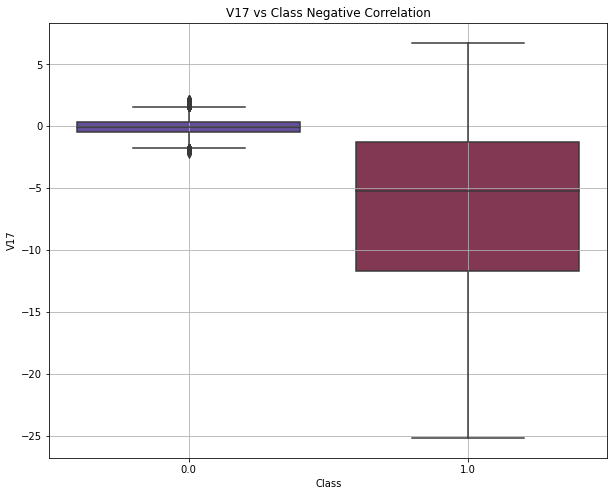

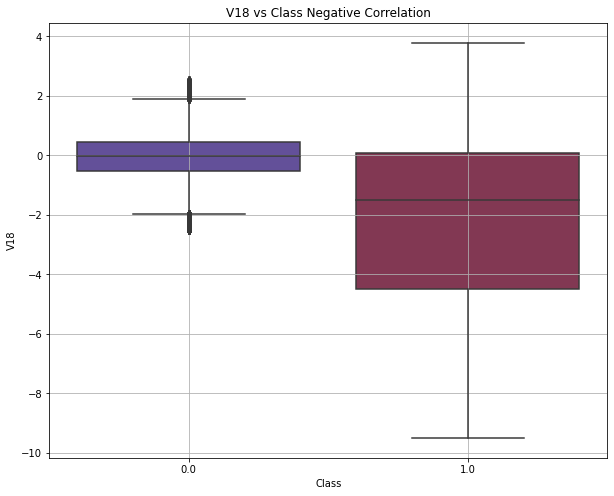

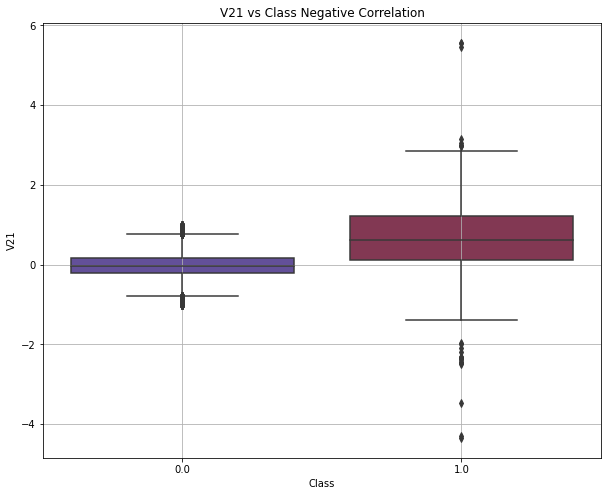

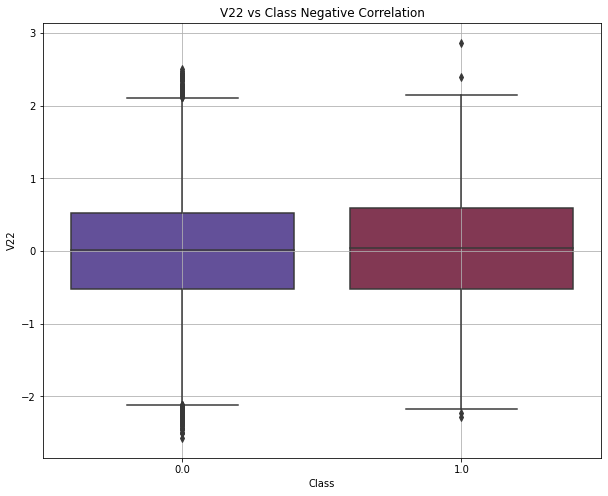

In [15]:
for i in output:
    box_plot(i,data)

If we remove the data from Class 1, between 5 % to 95 %, we end up getting only 100 data points for the respective class left.<br>Hence we are not deleting for Class 1

Vizualizing with PCA to check how the data is seperable.

In [9]:
def dimention_reduction(X_reduced_pca,y_1):
    sns.scatterplot(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y_1 == 0), cmap='coolwarm',linewidths=2)
    sns.scatterplot(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y_1 == 1), cmap='coolwarm',linewidths=2)
    plt.title('PCA', fontsize=14)
    plt.legend(handles=[red_patch,blue_patch])
    plt.grid()
    plt.show()


    sns.countplot(y_1)
    plt.title('Class Lables Count', fontsize=14)
    plt.show()

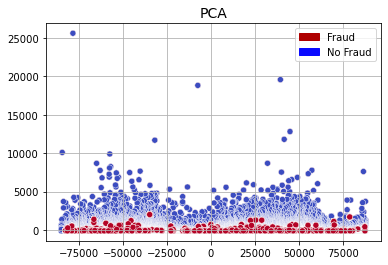

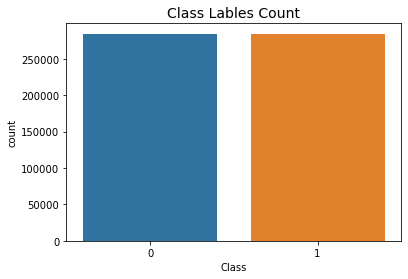

In [78]:
# Sampling Data

X_1,y_1 = sampling_data(X,y,"oversample")

# PCA Implementation
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X_1.values)
dimention_reduction(X_reduced_pca,y_1)

# Modelling

In [10]:
def hyperparameter_tuning(X_train,y_train):
    # Parameters
    log_support_param = {"penalty": ['l1', 'l2'], 'alpha': [0.001, 0.01, 0.1, 1]}
    dt_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,7,1)), "min_samples_leaf": list(range(5,7,1))}
    #knn_params = {"n_neighbors": [2,3,5,7,9]}

    # Logistic Regression
    logistic = SGDClassifier(max_iter=1000, loss = "log",early_stopping=True, validation_fraction=0.2)
    rand_log = RandomizedSearchCV(logistic, log_support_param)
    rand_log.fit(X_train, y_train)

    log_best = rand_log.best_estimator_
    print("\n")
    print("Logistic Regression Best Estimators: \n", log_best)
    print(f"Logistic Regression Best Score: {(rand_log.best_score_)*100} %")
    print("Logistic Regression Best Parameters: ", rand_log.best_params_)
    print("="*100)
    print("="*100)
    print("="*100)
    print("\n")

    # Support Vector Classifier
    support = SGDClassifier(max_iter=1000, loss = "hinge",early_stopping=True, validation_fraction=0.2)
    rand_supp = RandomizedSearchCV(support, log_support_param)
    rand_supp.fit(X_train, y_train)

    svc_best = rand_supp.best_estimator_
    print("\n")
    print("Support Vector Classifier Best Estimators: ", svc_best)
    print(f"Support Vector Classifier Best Score: {(rand_supp.best_score_)*100} %")
    print("Support Vector Classifier Best Parameters: ", rand_supp.best_params_)
    print("="*100)
    print("="*100)
    print("="*100)
    print("\n")
    # DecisionTree Classifier
    rand_tree = RandomizedSearchCV(DecisionTreeClassifier(), dt_params)
    rand_tree.fit(X_train, y_train)

    tree_best = rand_tree.best_estimator_
    print("\n")
    print("DecisionTree Classifier Best Estimators: ", tree_best)
    print(f"DecisionTree Classifier Best Score:  {(rand_tree.best_score_)*100} %")
    print("DecisionTree Classifier Best Parameters: ", rand_tree.best_params_)

Checking with Under Sampled Data

In [16]:
X_1,y_1 = sampling_data(X,y,"undersample")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
hyperparameter_tuning(X_train,y_train)



Logistic Regression Best Estimators: 
 SGDClassifier(alpha=0.001, early_stopping=True, loss='log', penalty='l1',
              validation_fraction=0.2)
Logistic Regression Best Score: 99.95880960149913 %
Logistic Regression Best Parameters:  {'penalty': 'l1', 'alpha': 0.001}




Support Vector Classifier Best Estimators:  SGDClassifier(alpha=0.001, early_stopping=True, penalty='l1',
              validation_fraction=0.2)
Support Vector Classifier Best Score: 99.96009676844467 %
Support Vector Classifier Best Parameters:  {'penalty': 'l1', 'alpha': 0.001}




DecisionTree Classifier Best Estimators:  DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=5)
DecisionTree Classifier Best Score:  99.97811766487 %
DecisionTree Classifier Best Parameters:  {'min_samples_leaf': 5, 'max_depth': 3, 'criterion': 'entropy'}


# DecisionTree Classifier is working best with the Under Sample data. With an Accuracy level of ~ 99.98 %

Checking with OverSampled Data

In [18]:
X_1,y_1 = sampling_data(X,y,"oversample")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
hyperparameter_tuning(X_train,y_train)



Logistic Regression Best Estimators: 
 SGDClassifier(alpha=0.001, early_stopping=True, loss='log', penalty='l1',
              validation_fraction=0.2)
Logistic Regression Best Score: 99.95044278853585 %
Logistic Regression Best Parameters:  {'penalty': 'l1', 'alpha': 0.001}




Support Vector Classifier Best Estimators:  SGDClassifier(alpha=0.001, early_stopping=True, penalty='l1',
              validation_fraction=0.2)
Support Vector Classifier Best Score: 99.94979914293116 %
Support Vector Classifier Best Parameters:  {'penalty': 'l1', 'alpha': 0.001}




DecisionTree Classifier Best Estimators:  DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=5)
DecisionTree Classifier Best Score:  99.98004841528832 %
DecisionTree Classifier Best Parameters:  {'min_samples_leaf': 5, 'max_depth': 4, 'criterion': 'entropy'}


# DecisionTree Classifier is working best with the Over Sample data. With an Accuracy level of ~ 99.98 %

In [20]:
X_1,y_1 = sampling_data(X,y,"smote")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
hyperparameter_tuning(X_train,y_train)



Logistic Regression Best Estimators: 
 SGDClassifier(alpha=0.001, early_stopping=True, loss='log', penalty='l1',
              validation_fraction=0.2)
Logistic Regression Best Score: 99.949799329327 %
Logistic Regression Best Parameters:  {'penalty': 'l1', 'alpha': 0.001}




Support Vector Classifier Best Estimators:  SGDClassifier(alpha=0.001, early_stopping=True, penalty='l1',
              validation_fraction=0.2)
Support Vector Classifier Best Score: 99.95559164271396 %
Support Vector Classifier Best Parameters:  {'penalty': 'l1', 'alpha': 0.001}




DecisionTree Classifier Best Estimators:  DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=5)
DecisionTree Classifier Best Score:  99.98197920712795 %
DecisionTree Classifier Best Parameters:  {'min_samples_leaf': 5, 'max_depth': 6, 'criterion': 'entropy'}


# DecisionTree Classifier is working best with the SMOTE Sample data. With an Accuracy level of ~ 99.98 %

In [26]:
X_1,y_1 = sampling_data(X,y,"nearmiss")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
hyperparameter_tuning(X_train,y_train)



Logistic Regression Best Estimators: 
 SGDClassifier(alpha=0.001, early_stopping=True, loss='log', penalty='l1',
              validation_fraction=0.2)
Logistic Regression Best Score: 99.9523735803755 %
Logistic Regression Best Parameters:  {'penalty': 'l1', 'alpha': 0.001}




Support Vector Classifier Best Estimators:  SGDClassifier(alpha=0.001, early_stopping=True, penalty='l1',
              validation_fraction=0.2)
Support Vector Classifier Best Score: 99.94658118414594 %
Support Vector Classifier Best Parameters:  {'penalty': 'l1', 'alpha': 0.001}




DecisionTree Classifier Best Estimators:  DecisionTreeClassifier(max_depth=4, min_samples_leaf=5)
DecisionTree Classifier Best Score:  99.98069204018239 %
DecisionTree Classifier Best Parameters:  {'min_samples_leaf': 5, 'max_depth': 4, 'criterion': 'gini'}


# DecisionTree Classifier is working best with the NearMiss Sample data. With an Accuracy level of ~ 99.98 %

# DT performs best form among all the classifiers, however it is performing by a very small margin.
To continue with our DT for the next stages.

UnderSample Model

In [45]:
def matrices(y_true,y_pred):
    conf_mat = confusion_matrix(y_true, y_pred)
    heat_map(conf_mat,"Confusion Matrix")
    print("\n")
    prec_mat = precision_score(y_true, y_pred)
    #heat_map(prec_mat,"Precision Matrix")
    
    rec_mat = recall_score(y_true, y_pred)
    #heat_map(prec_mat,"Recall Matrix")
    
    f1_scores = f1_score(y_true, y_pred)
    roc_score = roc_auc_score(y_true, y_pred)
    acc_score = accuracy_score(y_true, y_pred)
    print("Classification report for the Classification Model is: ")
    print(classification_report(y_true, y_pred))
    print("\n")
    print("Log Loss: ",log_loss(y_true, y_pred).round(3))
    print(f"F1 Score for the Classification: {f1_scores}")
    print("\n")
    print(f"ROC Score for the Classification: {roc_score}")
    print("\n")
    print(f"Accuracy Score for the Classification Model: {acc_score}")
    print("\n")
    print(f"Precision: {(prec_mat)*100} %")
    print(f"Recall {(rec_mat)*100} %")
def heat_map(matrix,name="Matrix"):
    sns.heatmap(matrix,cmap="PiYG",annot=True,linewidths=0.5);
    plt.xlabel("Prediction",fontsize=14)
    plt.ylabel("True",fontsize=14)
    plt.title(name, fontsize=14)
    plt.show()

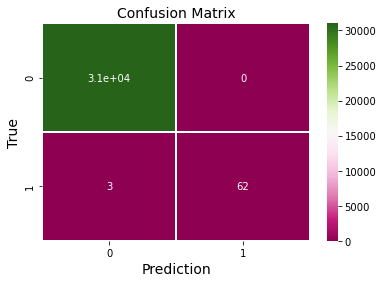



Classification report for the Classification Model is: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     31011
         1.0       1.00      0.95      0.98        65

    accuracy                           1.00     31076
   macro avg       1.00      0.98      0.99     31076
weighted avg       1.00      1.00      1.00     31076



F1 Score for the Classification: 0.9763779527559054


ROC Score for the Classification: 0.976923076923077


Accuracy Score for the Classification Model: 0.9999034624790836


Precision: 100.0 %
Recall 95.38461538461539 %


In [87]:
X_1,y_1 = sampling_data(X,y,"Undersample")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

dt_under = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=5)
dt_under.fit(X_train,y_train)
matrices(y_cv,dt_under.predict(X_cv))

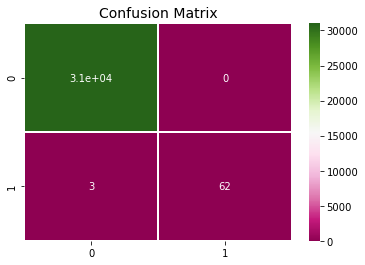







Classification report for the Classification Model is: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     31011
         1.0       1.00      0.95      0.98        65

    accuracy                           1.00     31076
   macro avg       1.00      0.98      0.99     31076
weighted avg       1.00      1.00      1.00     31076



F1 Score for the Classification: 0.9763779527559054


ROC Score for the Classification: 0.976923076923077


Accuracy Score for the Classification Model: 0.9999034624790836


Precision: 100.0 %
Recall 95.38461538461539 %


In [76]:
X_1,y_1 = sampling_data(X,y,"oversample")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

dt_over = DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=5)
dt_over.fit(X_train,y_train)
matrices(y_cv,dt_over.predict(X_cv))

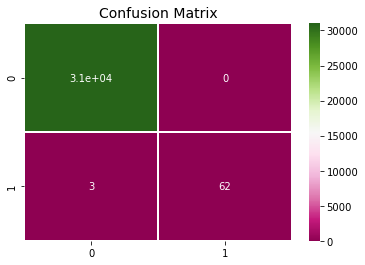







Classification report for the Classification Model is: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     31011
         1.0       1.00      0.95      0.98        65

    accuracy                           1.00     31076
   macro avg       1.00      0.98      0.99     31076
weighted avg       1.00      1.00      1.00     31076



F1 Score for the Classification: 0.9763779527559054


ROC Score for the Classification: 0.976923076923077


Accuracy Score for the Classification Model: 0.9999034624790836


Precision: 100.0 %
Recall 95.38461538461539 %


In [77]:
X_1,y_1 = sampling_data(X,y,"smote")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

dt_smote = DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=5)
dt_smote.fit(X_train,y_train)
matrices(y_cv,dt_smote.predict(X_cv))

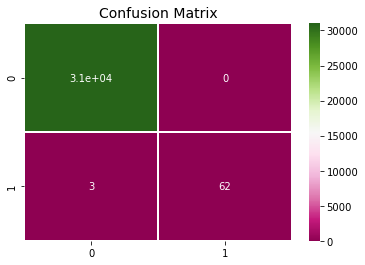







Classification report for the Classification Model is: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     31011
         1.0       1.00      0.95      0.98        65

    accuracy                           1.00     31076
   macro avg       1.00      0.98      0.99     31076
weighted avg       1.00      1.00      1.00     31076



F1 Score for the Classification: 0.9763779527559054


ROC Score for the Classification: 0.976923076923077


Accuracy Score for the Classification Model: 0.9999034624790836


Precision: 100.0 %
Recall 95.38461538461539 %


In [78]:
X_1,y_1 = sampling_data(X,y,"nearmiss")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

dt_near = DecisionTreeClassifier(max_depth=4, min_samples_leaf=5,criterion= 'gini')
dt_near.fit(X_train,y_train)
matrices(y_cv,dt_near.predict(X_cv))

# XGBoost

## NearMiss Sampling

In [24]:
# XGBoost Model Hyperparameter tuning
X_1,y_1 = sampling_data(X,y,"nearmiss")
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

In [26]:
param = {"learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
 'subsample':[0.6, 0.7, 0.8, 0.9],
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}
# fit model on sampled training data
model = XGBClassifier()
rand_xgb = RandomizedSearchCV(model, param,n_jobs=4,verbose=100,random_state=0,scoring='recall',return_train_score=True)
rand_xgb.fit(X_train, y_train)
print("="*100)
print("XGB Classifier Best Estimators: ", rand_xgb.best_estimator_)
print(f"XGB Classifier Best Score:  {(rand_xgb.best_score_)*100} %")
print("XGB Classifier Best Parameters: ", rand_xgb.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0900s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  18 tasks      | elapse

## Smote Sampling

In [27]:
# XGBoost Model Hyperparameter tuning
X_1,y_1 = sampling_data(X,y,"smote")
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

In [28]:
param = {"learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
 'subsample':[0.6, 0.7, 0.8, 0.9],
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}
# fit model on sampled training data
model = XGBClassifier()
rand_xgb = RandomizedSearchCV(model, param,n_jobs=4,verbose=100,random_state=0,scoring='recall',return_train_score=True)
rand_xgb.fit(X_train, y_train)
print("="*100)
print("XGB Classifier Best Estimators: ", rand_xgb.best_estimator_)
print(f"XGB Classifier Best Score:  {(rand_xgb.best_score_)*100} %")
print("XGB Classifier Best Parameters: ", rand_xgb.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:  4.9min
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:  4.9min
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:  5.0min
[Parallel(

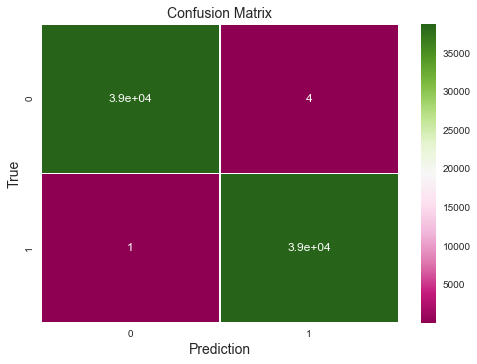



Classification report for the Classification Model is: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     38782
         1.0       1.00      1.00      1.00     38728

    accuracy                           1.00     77510
   macro avg       1.00      1.00      1.00     77510
weighted avg       1.00      1.00      1.00     77510



Log Loss:  0.002
F1 Score for the Classification: 0.9999354497217883


ROC Score for the Classification: 0.9999355191282037


Accuracy Score for the Classification Model: 0.9999354921945556


Precision: 99.98967235547752 %
Recall 99.99741788886594 %


In [37]:
# Lets see how it performs on test data
xgb_smote = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=10,
              min_child_weight=5, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)
xgb_smote.fit(X_train,y_train)
matrices(y_test,xgb_smote.predict(X_test))

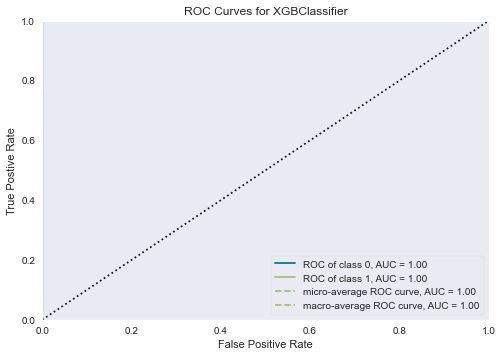

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>,
       classes=[0, 1], model=None)

In [33]:
roc_auc(xgb_smote,X_train,y_train,X_test = X_test, y_test = y_test,classes=[0,1])

# XGBoost with Smote Sampling provides best results both Precision and accuracy is at 1

In [39]:
# XGBoost Model Hyperparameter tuning
X_1,y_1 = sampling_data(X,y,"Oversample")
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

In [40]:
param = {"learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
 'subsample':[0.6, 0.7, 0.8, 0.9],
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}
# fit model on sampled training data
model = XGBClassifier()
rand_xgb = RandomizedSearchCV(model, param,n_jobs=4,verbose=100,random_state=0,scoring='recall',return_train_score=True)
rand_xgb.fit(X_train, y_train)
print("="*100)
print("XGB Classifier Best Estimators: ", rand_xgb.best_estimator_)
print(f"XGB Classifier Best Score:  {(rand_xgb.best_score_)*100} %")
print("XGB Classifier Best Parameters: ", rand_xgb.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:  4.2min
[Parallel(

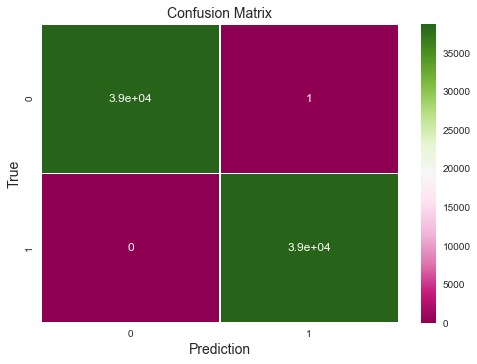



Classification report for the Classification Model is: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     38782
         1.0       1.00      1.00      1.00     38728

    accuracy                           1.00     77510
   macro avg       1.00      1.00      1.00     77510
weighted avg       1.00      1.00      1.00     77510



Log Loss:  0.0
F1 Score for the Classification: 0.99998708961101


ROC Score for the Classification: 0.9999871074209684


Accuracy Score for the Classification Model: 0.9999870984389111


Precision: 99.99741795553719 %
Recall 100.0 %


In [46]:
# Lets see how it performs on test data
xgb_ovr = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.25, max_delta_step=0, max_depth=10,
              min_child_weight=3, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)
xgb_ovr.fit(X_train,y_train)
matrices(y_test,xgb_ovr.predict(X_test))

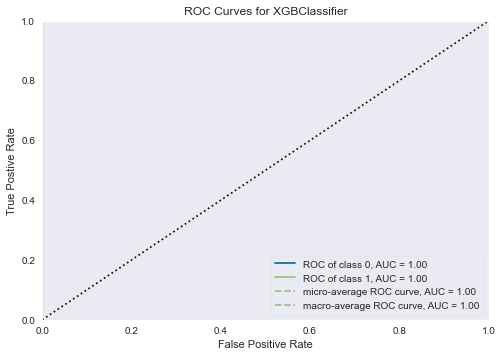

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>,
       classes=[0, 1], model=None)

In [42]:
roc_auc(xgb_ovr,X_train,y_train,X_test = X_test, y_test = y_test,classes=[0,1])

# XGBoost showing excellent result with both Recall and Precision at ~100%

In [47]:
# XGBoost Model Hyperparameter tuning
X_1,y_1 = sampling_data(X,y,"undersample")
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

In [48]:
param = {"learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
 'subsample':[0.6, 0.7, 0.8, 0.9],
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}
# fit model on sampled training data
model = XGBClassifier()
rand_xgb = RandomizedSearchCV(model, param,n_jobs=4,verbose=100,random_state=0,scoring='recall',return_train_score=True)
rand_xgb.fit(X_train, y_train)
print("="*100)
print("XGB Classifier Best Estimators: ", rand_xgb.best_estimator_)
print(f"XGB Classifier Best Score:  {(rand_xgb.best_score_)*100} %")
print("XGB Classifier Best Parameters: ", rand_xgb.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    4.4s
[Parallel(

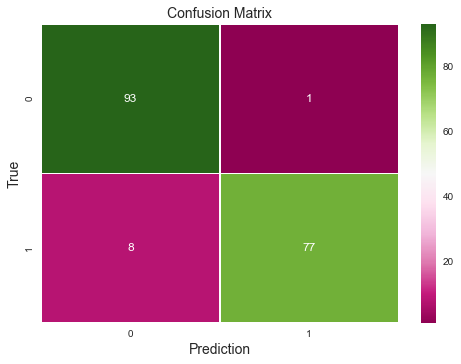



Classification report for the Classification Model is: 
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95        94
         1.0       0.99      0.91      0.94        85

    accuracy                           0.95       179
   macro avg       0.95      0.95      0.95       179
weighted avg       0.95      0.95      0.95       179



Log Loss:  1.737
F1 Score for the Classification: 0.9447852760736197


ROC Score for the Classification: 0.9476220275344179


Accuracy Score for the Classification Model: 0.9497206703910615


Precision: 98.71794871794873 %
Recall 90.58823529411765 %


In [49]:
# Lets see how it performs on test data
xgb_und = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=15,
              min_child_weight=5, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)
xgb_und.fit(X_train,y_train)
matrices(y_test,xgb_und.predict(X_test))

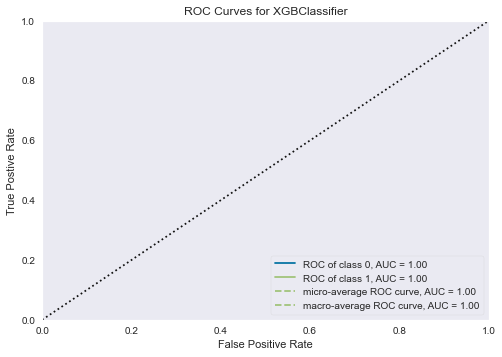

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>,
       classes=[0, 1], model=None)

In [50]:
roc_auc(xgb_ovr,X_train,y_train,X_test = X_test, y_test = y_test,classes=[0,1])

# XGBoost with Oversampling is producing best results, with both Precision and Recall at ~100%